In [ ]:
import ast
import re
import json

class Node:
    def __init__(self, node_type, value=None, loc=None):
        self.node_type = node_type
        self.value = value
        self.children = []
        self.loc = loc

    def add_child(self, child_node):
        self.children.append(child_node)

    def __repr__(self):
        loc_repr = f', loc={self.loc}' if self.loc else ''
        return f'Node(type={self.node_type}, value={self.value}, children={len(self.children)}{loc_repr})'

class LibraryUsageNode(Node):
    def __init__(self, value, loc=None):
        super().__init__(node_type="LibraryUsage", value=value, loc=loc)

class CommentNode(Node):
    def __init__(self, value, loc=None):
        super().__init__(node_type="Comment", value=value, loc=loc)

class UAST:
    def __init__(self):
        self.root = None
        self.nodes = []

    def set_root(self, node):
        self.root = node

    def add_node(self, parent, node):
        parent.add_child(node)
        self.nodes.append(node)

    def traverse(self, node=None, depth=0):
        if node is None:
            node = self.root
        print('  ' * depth + repr(node))
        for child in node.children:
            self.traverse(child, depth + 1)

def extract_comments_and_library_usages(code, language):
    comments = []
    library_usages = []

    if language == "python":
        # Extract library usages and comments with location
        ast_tree = ast.parse(code)
        for node in ast_tree.body:
            if isinstance(node, ast.Import):
                for alias in node.names:
                    library_usages.append((alias.name, node.lineno, node.col_offset, node.end_lineno, node.end_col_offset))
        
        # Extract comments directly from the source code
        for match in re.finditer(r'#.*', code):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = start_line
            end_col = start_col + len(comment)
            comments.append((comment, start_line, start_col, end_line, end_col))

    elif language == "cpp":
        # Extract include directives with location
        for match in re.finditer(r'#include\s*<([^>]*)>', code):
            include = match.group(1)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = start_line
            end_col = start_col + len(match.group(0))
            library_usages.append((include, start_line, start_col, end_line, end_col))
        
        # Extract comments with location
        for match in re.finditer(r'(?://[^\n]*|/\*.*?\*/)', code, re.DOTALL):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = code[:match.end()].count('\n')
            if end_line > 0:
                end_line += start_line - 1
                end_col = len(code[:match.end()].split('\n')[-1])
            else:
                end_line = start_line
                end_col = start_col + len(comment)
            comments.append((comment, start_line, start_col, end_line, end_col))

    elif language == "java":
        # Extract import statements with location
        for match in re.finditer(r'import\s+([^;]+);', code):
            imp = match.group(1).strip()
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = start_line
            end_col = start_col + len(match.group(0))
            library_usages.append((imp, start_line, start_col, end_line, end_col))
        
        # Extract comments with location
        for match in re.finditer(r'(?://[^\n]*|/\*.*?\*/)', code, re.DOTALL):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = code[:match.end()].count('\n')
            if end_line > 0:
                end_line += start_line - 1
                end_col = len(code[:match.end()].split('\n')[-1])
            else:
                end_line = start_line
                end_col = start_col + len(comment)
            comments.append((comment, start_line, start_col, end_line, end_col))



    elif language == "c":
        # Extract include directives with location
        for match in re.finditer(r'#include\s*<([^>]*)>', code):
            include = match.group(1)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = start_line
            end_col = start_col + len(match.group(0))
            library_usages.append((include, start_line, start_col, end_line, end_col))
        
        # Extract comments with location
        for match in re.finditer(r'(?://[^\n]*|/\*.*?\*/)', code, re.DOTALL):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = code[:match.end()].count('\n')
            if end_line > 0:
                end_line += start_line - 1
                end_col = len(code[:match.end()].split('\n')[-1])
        else:
            end_line = start_line
            end_col = start_col + len(comment)
        comments.append((comment, start_line, start_col, end_line, end_col))
    return comments, library_usages
    """ elif language == "go":
        # Extract import statements with location
        for match in re.finditer(r'import\s+\(([\w\s."\/\\-]+)\)', code):
            imp = match.group(1).strip()
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = match.end() - match.group(1).rfind('\n') - 1
            end_col = len(match.group(1))
            library_usages.append((imp, start_line, start_col, end_line, end_col))
        
        # Extract comments with location
        for match in re.finditer(r'(?://[^\n]*|/\*.*?\*/)', code, re.DOTALL):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = code[:match.end()].count('\n')
            if end_line > 0:
                end_line += start_line - 1
                end_col = len(code[:match.end()].split('\n')[-1])
            else:
                end_line = start_line
                end_col = start_col + len(comment)
            comments.append((comment, start_line, start_col, end_line, end_col))"""
def detect_language(code):
    if re.search(r'import\s+\w+(\.\w+)*;', code):
        return "java"
    elif re.search(r'#include\s*<[^>]*>', code):
        return "cpp"
    elif re.search(r'import\s+\w+', code):
        return "python"
    elif re.search(r'import\s+(?:\([\w\s."\/\\-]+\)|[\w\s."\/\\-]+);', code):
        return "go"
    elif re.search(r'#include\s*<[^>]*>', code):
        return "c"
    else:
        return None


def uast_to_json(node):
    node_dict = {
        "type": node.node_type,
        "value": node.value,
        "loc": node.loc,
        "children": [uast_to_json(child) for child in node.children]
    }
    return node_dict

def main():
    file_path = input("Enter the path to the code file: ")
    try:
        with open(file_path, 'r') as file:
            code = file.read()
    except Exception as e:
        print(f"Error reading file: {e}")
        return

    language = detect_language(code)
    if not language:
        print("Language could not be detected.")
        return

    uast = UAST()
    root_node = Node("Program", loc={
        "start": {"line": 1, "column": 0},
        "end": {"line": code.count('\n') + 1, "column": 0}
    })
    uast.set_root(root_node)

    comments, library_usages = extract_comments_and_library_usages(code, language)

    # Add library usage nodes
    for lib_usage, start_line, start_col, end_line, end_col in library_usages:
        lib_usage_node = LibraryUsageNode(lib_usage, loc={
            "start": {"line": start_line, "column": start_col},
            "end": {"line": end_line, "column": end_col}
        })
        uast.add_node(root_node, lib_usage_node)

    # Add comment nodes
    for comment, start_line, start_col, end_line, end_col in comments:
        comment_node = CommentNode(comment.strip(), loc={
            "start": {"line": start_line, "column": start_col},
            "end": {"line": end_line, "column": end_col}
        })
        uast.add_node(root_node, comment_node)

    print(f"\nTraversing the UAST for {language.capitalize()}:")
    uast.traverse()

    uast_json = uast_to_json(uast.root)
    print(f"\nJSON for {language.capitalize()} UAST:")
    print(json.dumps(uast_json, indent=2))

if __name__ == "__main__":
    main()


In [ ]:
!pip3 install networkx
!pip3 install matplotlib


Traversing the UAST for Python:
Node(type=Program, value=None, children=9, loc={'start': {'line': 1, 'column': 0}, 'end': {'line': 14, 'column': 0}})
  Node(type=LibraryUsage, value=math, children=0, loc={'start': {'line': 2, 'column': 0}, 'end': {'line': 2, 'column': 11}})
  Node(type=LibraryUsage, value=math, children=0, loc={'start': {'line': 3, 'column': 0}, 'end': {'line': 3, 'column': 16}})
  Node(type=LibraryUsage, value=importlib, children=0, loc={'start': {'line': 6, 'column': 0}, 'end': {'line': 6, 'column': 16}})
  Node(type=LibraryUsage, value=os, children=0, loc={'start': {'line': 14, 'column': 0}, 'end': {'line': 14, 'column': 9}})
  Node(type=Comment, value=# Importing math library, children=0, loc={'start': {'line': 2, 'column': 12}, 'end': {'line': 2, 'column': 37}})
  Node(type=Comment, value=# Import with alias, children=0, loc={'start': {'line': 3, 'column': 17}, 'end': {'line': 3, 'column': 36}})
  Node(type=Comment, value=# Import specific items from a module, ch

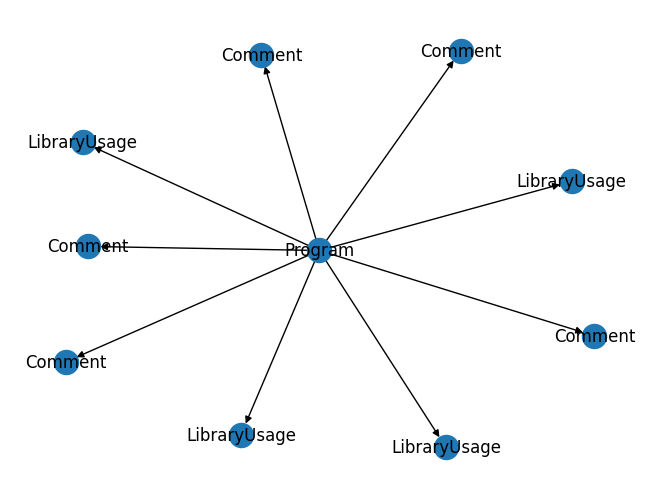

In [24]:
import ast
import re
import json
import networkx as nx
import matplotlib.pyplot as plt
class Node:
    def __init__(self, node_type, value=None, loc=None):
        self.node_type = node_type
        self.value = value
        self.children = []
        self.loc = loc

    def add_child(self, child_node):
        self.children.append(child_node)

    def __repr__(self):
        loc_repr = f', loc={self.loc}' if self.loc else ''
        return f'Node(type={self.node_type}, value={self.value}, children={len(self.children)}{loc_repr})'

class LibraryUsageNode(Node):
    def __init__(self, value, loc=None):
        super().__init__(node_type="LibraryUsage", value=value, loc=loc)

class CommentNode(Node):
    def __init__(self, value, loc=None):
        super().__init__(node_type="Comment", value=value, loc=loc)

class UAST:
    def __init__(self):
        self.root = None
        self.nodes = []

    def set_root(self, node):
        self.root = node

    def add_node(self, parent, node):
        parent.add_child(node)
        self.nodes.append(node)

    def traverse(self, node=None, depth=0):
        if node is None:
            node = self.root
        print('  ' * depth + repr(node))
        for child in node.children:
            self.traverse(child, depth + 1)

    def to_networkx(self):
        graph = nx.DiGraph()
        self._add_edges(graph, self.root)
        return graph

    def _add_edges(self, graph, node):
        if node:
            graph.add_node(node, type=node.node_type, value=node.value, loc=node.loc)
            for child in node.children:
                graph.add_edge(node, child)
                self._add_edges(graph, child)

def visualize_graph(graph):
    pos = nx.spring_layout(graph)
    labels = {node: node.node_type for node in graph.nodes()}
    nx.draw(graph, pos, labels=labels, with_labels=True, arrows=True)
    plt.show()

def extract_comments_and_library_usages(code, language):
    comments = []
    library_usages = []

    if language == "python":
        # Extract library usages and comments with location
        ast_tree = ast.parse(code)
        for node in ast_tree.body:
            if isinstance(node, ast.Import):
                for alias in node.names:
                    library_usages.append((alias.name, node.lineno, node.col_offset, node.end_lineno, node.end_col_offset))
        
        # Extract comments directly from the source code
        for match in re.finditer(r'#.*', code):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = start_line
            end_col = start_col + len(comment)
            comments.append((comment, start_line, start_col, end_line, end_col))

    elif language == "cpp":
        # Extract include directives with location
        for match in re.finditer(r'#include\s*<([^>]*)>', code):
            include = match.group(1)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = start_line
            end_col = start_col + len(match.group(0))
            library_usages.append((include, start_line, start_col, end_line, end_col))
        
        # Extract comments with location
        for match in re.finditer(r'(?://[^\n]*|/\*.*?\*/)', code, re.DOTALL):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = code[:match.end()].count('\n')
            if end_line > 0:
                end_line += start_line - 1
                end_col = len(code[:match.end()].split('\n')[-1])
            else:
                end_line = start_line
                end_col = start_col + len(comment)
            comments.append((comment, start_line, start_col, end_line, end_col))

    elif language == "java":
        # Extract import statements with location
        for match in re.finditer(r'import\s+([^;]+);', code):
            imp = match.group(1).strip()
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = start_line
            end_col = start_col + len(match.group(0))
            library_usages.append((imp, start_line, start_col, end_line, end_col))
        
        # Extract comments with location
        for match in re.finditer(r'(?://[^\n]*|/\*.*?\*/)', code, re.DOTALL):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = code[:match.end()].count('\n')
            if end_line > 0:
                end_line += start_line - 1
                end_col = len(code[:match.end()].split('\n')[-1])
            else:
                end_line = start_line
                end_col = start_col + len(comment)
            comments.append((comment, start_line, start_col, end_line, end_col))



    elif language == "c":
        # Extract include directives with location
        for match in re.finditer(r'#include\s*<([^>]*)>', code):
            include = match.group(1)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = start_line
            end_col = start_col + len(match.group(0))
            library_usages.append((include, start_line, start_col, end_line, end_col))
        
        # Extract comments with location
        for match in re.finditer(r'(?://[^\n]*|/\*.*?\*/)', code, re.DOTALL):
            comment = match.group(0)
            start_line = code[:match.start()].count('\n') + 1
            start_col = match.start() - code[:match.start()].rfind('\n') - 1
            end_line = code[:match.end()].count('\n')
            if end_line > 0:
                end_line += start_line - 1
                end_col = len(code[:match.end()].split('\n')[-1])
        else:
            end_line = start_line
            end_col = start_col + len(comment)
        comments.append((comment, start_line, start_col, end_line, end_col))
    return comments, library_usages
   
def detect_language(code):
    if re.search(r'import\s+\w+(\.\w+)*;', code):
        return "java"
    elif re.search(r'#include\s*<[^>]*>', code):
        return "cpp"
    elif re.search(r'import\s+\w+', code):
        return "python"
    elif re.search(r'import\s+(?:\([\w\s."\/\\-]+\)|[\w\s."\/\\-]+);', code):
        return "go"
    elif re.search(r'#include\s*<[^>]*>', code):
        return "c"
    else:
        return None


def uast_to_json(node):
    node_dict = {
        "type": node.node_type,
        "value": node.value,
        "loc": node.loc,
        "children": [uast_to_json(child) for child in node.children]
    }
    return node_dict

def main():
    file_path = input("Enter the path to the code file: ")
    try:
        with open(file_path, 'r') as file:
            code = file.read()
    except Exception as e:
        print(f"Error reading file: {e}")
        return

    language = detect_language(code)
    if not language:
        print("Language could not be detected.")
        return

    uast = UAST()
    root_node = Node("Program", loc={
        "start": {"line": 1, "column": 0},
        "end": {"line": code.count('\n') + 1, "column": 0}
    })
    uast.set_root(root_node)

    comments, library_usages = extract_comments_and_library_usages(code, language)

    # Add library usage nodes
    for lib_usage, start_line, start_col, end_line, end_col in library_usages:
        lib_usage_node = LibraryUsageNode(lib_usage, loc={
            "start": {"line": start_line, "column": start_col},
            "end": {"line": end_line, "column": end_col}
        })
        uast.add_node(root_node, lib_usage_node)

    # Add comment nodes
    for comment, start_line, start_col, end_line, end_col in comments:
        comment_node = CommentNode(comment.strip(), loc={
            "start": {"line": start_line, "column": start_col},
            "end": {"line": end_line, "column": end_col}
        })
        uast.add_node(root_node, comment_node)

    print(f"\nTraversing the UAST for {language.capitalize()}:")
    uast.traverse()

    uast_json = uast_to_json(uast.root)
    print(f"\nJSON for {language.capitalize()} UAST:")
    print(json.dumps(uast_json, indent=2))

    # Convert UAST to NetworkX graph and visualize
    graph = uast.to_networkx()
    visualize_graph(graph)

if __name__ == "__main__":
    main()
